# Import necessary libraries

In [ ]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from keras.datasets import mnist

# Train reference model
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

from keras.models import Sequential
from keras import layers
from keras.callbacks import ModelCheckpoint

Mounted at /content/drive


# Load MNIST Digit dataset and quickly visualize input

11493376/11490434 [==============================] - 0s 0us/step


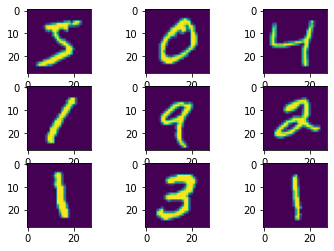

In [ ]:
# Load dataset
(X_train_full, y_train_full), (X_test, y_test) = mnist.load_data()

for i in range(0,9):
    plt.subplot(330 + 1 + i)
    plt.imshow(X_train_full[i])
plt.show()

X_train_full, X_test = X_train_full / 255., X_test / 255.

# Define multi layer perceptron model and evaluate its performance

In [ ]:
model = Sequential()
model.add(layers.Dropout(0.2, input_shape=(28, 28)))
model.add(layers.Flatten())
model.add(layers.Dense(256, activation="relu"))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(128, activation="relu"))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(10, activation='softmax'))

save_best_option = ModelCheckpoint('/content/drive/My Drive/mnist.h5', save_best_only=True, monitor='val_loss', mode='min')
lr_reducer_option = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.1, patience=3, verbose=0,
    mode='auto', min_delta=0.001, cooldown=2, min_lr=10e-6
)
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
model.save("/content/drive/My Drive/mnist_global.h5")

# train the model
history = model.fit(X_train_full, y_train_full, epochs=16, batch_size=32, validation_split=0.1, shuffle=True, callbacks=[save_best_option, lr_reducer_option])

# measure performance on test set of traditional approach
model = keras.models.load_model("/content/drive/My Drive/mnist.h5")
evaluation = model.evaluate(X_test, y_test)
accuracy_mlp_all_data = evaluation[1]

Epoch 1/16
1688/1688 [==============================] - 6s 3ms/step - loss: 0.5377 - accuracy: 0.8326 - val_loss: 0.1043 - val_accuracy: 0.9700
Epoch 2/16
1688/1688 [==============================] - 5s 3ms/step - loss: 0.1730 - accuracy: 0.9471 - val_loss: 0.0909 - val_accuracy: 0.9723
Epoch 3/16
1688/1688 [==============================] - 5s 3ms/step - loss: 0.1291 - accuracy: 0.9593 - val_loss: 0.0793 - val_accuracy: 0.9760
Epoch 4/16
1688/1688 [==============================] - 5s 3ms/step - loss: 0.1089 - accuracy: 0.9670 - val_loss: 0.0745 - val_accuracy: 0.9780
Epoch 5/16
1688/1688 [==============================] - 5s 3ms/step - loss: 0.1030 - accuracy: 0.9673 - val_loss: 0.0701 - val_accuracy: 0.9792
Epoch 6/16
1688/1688 [==============================] - 5s 3ms/step - loss: 0.0912 - accuracy: 0.9713 - val_loss: 0.0708 - val_accuracy: 0.9788
Epoch 7/16
1688/1688 [==============================] - 6s 3ms/step - loss: 0.0824 - accuracy: 0.9751 - val_loss: 0.0637 - val_accuracy:

# Now define function that learns a submodel for num_clients clients (based on equally sized subsets of training data) in num_iter averaging iterations

In [ ]:
def performance_on_n_clients(num_clients, num_iter):
  model = Sequential()
  model.add(layers.Dropout(0.2, input_shape=(28, 28)))
  model.add(layers.Flatten())
  model.add(layers.Dense(256, activation="relu"))
  model.add(layers.Dropout(0.2))
  model.add(layers.Dense(128, activation="relu"))
  model.add(layers.Dropout(0.2))
  model.add(layers.Dense(10, activation='softmax'))
  model.compile(optimizer='adam',
                loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                metrics=['accuracy'])
  model.save("/content/drive/My Drive/mnist_global.h5")
  
  items_per_num_clients = int(len(X_train_full) / num_clients)
  # trains n models based on subset of dataset
  aggregated_performance = 0.
  for iter_idx in range(num_iter):
    for client_idx in range(num_clients):
      # generate random boolean mask the length of data
      # use p 0.75 for False and 0.25 for True -> choose 25% sub samples
      mask = np.random.choice([False, True], items_per_num_clients, p=[0.75, 0.25])
      from_idx = items_per_num_clients * client_idx
      to_idx = from_idx + items_per_num_clients
      x_client = X_train_full[from_idx:to_idx][mask]
      y_client = y_train_full[from_idx:to_idx][mask]
      model = keras.models.load_model("/content/drive/My Drive/mnist_global.h5")

      save_best_option = ModelCheckpoint('/content/drive/My Drive/mnist_' + str(client_idx) + '.h5', save_best_only=True, monitor='val_loss', mode='min')
      lr_reducer_option = tf.keras.callbacks.ReduceLROnPlateau(
          monitor='val_loss', factor=0.1, patience=3, verbose=0,
          mode='auto', min_delta=0.001, cooldown=2, min_lr=10e-6
      )
      model.compile(optimizer='adam',
                    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                    metrics=['accuracy'])

      # train the model
      history = model.fit(x_client, y_client, epochs=4, batch_size=32, validation_split=0.1, shuffle=True, callbacks=[save_best_option, lr_reducer_option])

    # evaluate averaged model
    # now do parameter averaging over all models
    models = []
    for client_idx in range(num_clients):
      models.append(keras.models.load_model("/content/drive/My Drive/mnist_" + str(client_idx) + ".h5"))
    weights = [model.get_weights() for model in models]

    new_weights = []

    for weights_list_tuple in zip(*weights):
        new_weights.append(
            np.array([np.array(weights_).mean(axis=0) for weights_ in zip(*weights_list_tuple)]))

    # set averaged parameters on model and evaluate performance
    new_model = keras.models.load_model("/content/drive/My Drive/mnist.h5")
    new_model.set_weights(np.array(new_weights))
    new_model.save("/content/drive/My Drive/mnist_global.h5")

    aggregated_performances = new_model.evaluate(X_test, y_test)
    aggregated_performance = aggregated_performances[1]
    print("Aggregated performance at iter ", iter_idx, ": ", aggregated_performance)
  return aggregated_performance


# Now evaluate for different number of clients how the performance differs with parameter averaging

In [ ]:
all_accs = [accuracy_mlp_all_data] 
for n in range(2, 5):
  all_accs.append(performance_on_n_clients(n, 4))
print(all_accs)
  

Epoch 1/4
213/213 [==============================] - 1s 4ms/step - loss: 1.1633 - accuracy: 0.6229 - val_loss: 0.3597 - val_accuracy: 0.8967
Epoch 2/4
213/213 [==============================] - 1s 3ms/step - loss: 0.3589 - accuracy: 0.8971 - val_loss: 0.2785 - val_accuracy: 0.9007
Epoch 3/4
213/213 [==============================] - 1s 4ms/step - loss: 0.2454 - accuracy: 0.9288 - val_loss: 0.2590 - val_accuracy: 0.9166
Epoch 4/4
213/213 [==============================] - 1s 3ms/step - loss: 0.2173 - accuracy: 0.9270 - val_loss: 0.2003 - val_accuracy: 0.9311
Epoch 1/4
210/210 [==============================] - 1s 4ms/step - loss: 1.1350 - accuracy: 0.6297 - val_loss: 0.2055 - val_accuracy: 0.9343
Epoch 2/4
210/210 [==============================] - 1s 3ms/step - loss: 0.3540 - accuracy: 0.9010 - val_loss: 0.1591 - val_accuracy: 0.9531
Epoch 3/4
210/210 [==============================] - 1s 3ms/step - loss: 0.2645 - accuracy: 0.9180 - val_loss: 0.1317 - val_accuracy: 0.9571
Epoch 4/4
210

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


313/313 [==============================] - 1s 2ms/step - loss: 0.1706 - accuracy: 0.9481
Aggregated performance at iter  0 :  0.9480999708175659
Epoch 1/4
211/211 [==============================] - 1s 4ms/step - loss: 0.2471 - accuracy: 0.9249 - val_loss: 0.1627 - val_accuracy: 0.9492
Epoch 2/4
211/211 [==============================] - 1s 3ms/step - loss: 0.1946 - accuracy: 0.9409 - val_loss: 0.1453 - val_accuracy: 0.9559
Epoch 3/4
211/211 [==============================] - 1s 4ms/step - loss: 0.1516 - accuracy: 0.9529 - val_loss: 0.1535 - val_accuracy: 0.9532
Epoch 4/4
211/211 [==============================] - 1s 3ms/step - loss: 0.1288 - accuracy: 0.9560 - val_loss: 0.1295 - val_accuracy: 0.9599
Epoch 1/4
210/210 [==============================] - 1s 4ms/step - loss: 0.2624 - accuracy: 0.9187 - val_loss: 0.1354 - val_accuracy: 0.9598
Epoch 2/4
210/210 [==============================] - 1s 4ms/step - loss: 0.2138 - accuracy: 0.9360 - val_loss: 0.1157 - val_accuracy: 0.9692
Epoch 3/4

# Plot result for different number of clients

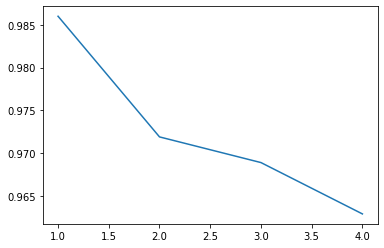

In [ ]:
plt.plot([1,2,3,4], all_accs)
plt.show()